## ***Libraries***

In [30]:
#Import useful libraries--------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import time
import seaborn as sns
import pandas as pd
from os import name
from time import strftime
from email.mime.multipart import MIMEMultipart
from email.mime.base import MIMEBase
from smtplib import SMTP
from email import encoders
'''
1.filtrar datos basura= (na, trash_data)
2.agupar por dia, mes y año= (year, dayofmounth ,mounth)
3.calcular la tardanza  por envios= (Actual_Shipment_Time, Planned_Shipment_Time)
4.grafica de eficiencia de envios por mes= (2.(Actual_Shipment_Time, Planned_Shipment_Time))
5.grafica de eficiencia de envios por mes, nombre y numero de trasportista= (2.(4.(Carrier_Name, Carrier_Num)))
6.grafica de eficiencia de envios por mes, origen y destino= (2.(4.(origen, destino)))

7.grafica de eficiencia de entrega por mes, nombre y numero de trasportista
8.grafica de eficiencia de entrega por mes, origen y destino

   '''

'\n1.filtrar datos basura= (na, trash_data)\n2.agupar por dia, mes y año= (year, dayofmounth ,mounth)\n3.calcular la tardanza  por envios= (Actual_Shipment_Time, Planned_Shipment_Time)\n4.grafica de eficiencia de envios por mes= (2.(Actual_Shipment_Time, Planned_Shipment_Time))\n5.grafica de eficiencia de envios por mes, nombre y numero de trasportista= (2.(4.(Carrier_Name, Carrier_Num)))\n6.grafica de eficiencia de envios por mes, origen y destino= (2.(4.(origen, destino)))\n\n7.grafica de eficiencia de entrega por mes, nombre y numero de trasportista\n8.grafica de eficiencia de entrega por mes, origen y destino\n\n   '

## ***Data Extraction***

In [21]:
#Data extraction----------------------------------------------------------------


from google.colab import drive
drive.mount('/content/drive')

deliv=pd.read_csv('/content/drive/MyDrive/delivery_dataset.csv',sep=';')


data=pd.DataFrame(deliv[(deliv['Year']==2020)&(deliv['Month']==1)])



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## ***PIE GRAPHS***

In [36]:
from IPython.utils.path import glob

def data_NA_drop(data):
  data =data.dropna()
  data =data.reset_index(drop=True)
  return data

def trash_data(trash):
  global data
  data=data.drop([trash])
  data =data.reset_index(drop=True)

def Timedata_filter(timedata):
  timefilter =[]
  trash =0
  for i in timedata:
    i=str(i)
    i=i.replace(":","").replace(".0","")
    if len(i)==3 or len(i)==4:
      timefilter.append(i)
      trash +=1
    else:
      trash_data(trash)
      trash +=1
  return timefilter

def time_separation(time_format):
  hours=[]
  minutes=[]
  for i in time_format:
    i=str(i)
    i=i.replace(":","").replace(".0","")
    if len(i)==3 or len(i)==4:
      ho=i[:-2]
      mi=i[-2:]
      hours.append(ho)
      minutes.append(mi)
  return hours,minutes

def time_rename():
  global data
  h,m=time_separation(data["Actual_Shipment_Time"])
  for i,x,y in zip(data["Actual_Shipment_Time"],h,m):
    data.loc[data.Actual_Shipment_Time==i,"Actual_Shipment_Time"]=str(x)+":"+str(y)

  h,m=time_separation(data["Planned_Shipment_Time"])
  for i,x,y in zip(data["Planned_Shipment_Time"],h,m):
    data.loc[data.Planned_Shipment_Time==i,"Planned_Shipment_Time"]=str(x)+":"+str(y)

  h,m=time_separation(data["Planned_Delivery_Time"])
  for i,x,y in zip(data["Planned_Delivery_Time"],h,m):
    data.loc[data.Planned_Delivery_Time==i,"Planned_Delivery_Time"]=str(x)+":"+str(y)
  
  delay=Shipping_delay(data["Actual_Shipment_Time"],data["Planned_Shipment_Time"])
  if "Shipment_Delay" in data.columns:
    for i,e in zip(data["Shipment_Delay"],delay):
      data.loc[data.Shipment_Delay==i,"Shipment_Delay"]=int(e)
  else:
    temporal={"t":[]}
    for e in delay:
      temporal["t"].append(int(e))

    temporal=pd.DataFrame(temporal)
    pas=temporal["t"]
    data=data.assign(Shipment_Delay=pas.values)

def Shipping_expectation(ast,pst):
  time_sh={"S":[]}
  for x,y in zip(ast,pst): 
    if x==y:
      time_sh["S"].append("rigth")
    elif x<y:
      time_sh["S"].append("early")
    elif x>y:
      time_sh["S"].append("late")
  return time_sh

def Shipping_delay(ast,pst):
  time_de=[]
  h1,m1=time_separation(ast)
  h2,m2=time_separation(pst)
  for x1,y1,x2,y2 in zip(h1,m1,h2,m2):
    h3=60*(int(x1)-int(x2))
    time_de.append((h3+int(y1))-int(y2))
  return time_de
  
def Delivery_expectation(sdt):
  time_del={"D":[]}
  for x in sdt: 
    if x==0:
      time_del["D"].append("rigth")
    elif x<0:
      time_del["D"].append("early")
    elif x>0:
      time_del["D"].append("late")
  return time_del 

def Delivery_efficiency(data):
  return data.value_counts().plot(kind="pie",labels=["late","early","rigth"],title="Delivery",autopct='%1.2f%%')


def Shipment_efficiency(A_Stime,P_Stime):
  shipping_expec=Shipping_expectation(A_Stime,P_Stime)
  shipping_expec=pd.DataFrame(shipping_expec)
  return shipping_expec.value_counts().plot(kind="pie",labels=["late","early","rigth"],title="shipping",autopct='%1.2f%%')


def Delay_day(data):
  total_delay={}
  for i in data["DayofMonth"]:
    total_delay[i]=0
  inde=0
  coun=0
  for i in data["Shipment_Delay"]:
    coun =coun+i
    total_delay[data["DayofMonth"][inde]]=int(coun)
    inde +=1
  total_delay=pd.DataFrame([[Key,total_delay[Key]] for Key in total_delay.keys()],columns=["days","total_minutes_delay"])

  plt.bar(total_delay["days"],total_delay["total_minutes_delay"])
  return plt.xlabel("Delay per mounth")


data=data_NA_drop(data)
A_Stime=Timedata_filter(data["Actual_Shipment_Time"])
P_Stime=Timedata_filter(data["Planned_Shipment_Time"])
P_Dtime=Timedata_filter(data["Planned_Delivery_Time"])
time_rename()
S_Dtime=data["Shipment_Delay"]
D_Status=data["Delivery_Status"]

Shipment_efficiency(A_Stime,P_Stime)
Delivery_efficiency(D_Status)
Delay_day(data)

PACKAGES_per_Month()


with PdfPages('Performance graphs.pdf') as pdf:
    txt='Efficiency per month'
    firstpage=plt.figure(figsize=(8.50,8.00))
    firstpage.clf()
    firstpage.text(0.5,0.5,txt,transform=firstpage.transFigure,size=24,ha='center')
    pdf.savefig()
    plt.close()
    
    Shipment_efficiency(A_Stime,P_Stime)
    pdf.savefig()
    plt.close()

    Delivery_efficiency(D_Status)
    pdf.savefig()
    plt.close()

    Delay_day(data)
    pdf.savefig()
    plt.close()



mes_y_año=str(time.strftime("%m"))+"_"+"2020"#str(time.strftime("%Y")

data.to_csv(f'Delivery report {mes_y_año}.csv',index=False)

mensaje=MIMEMultipart()
mensaje["From"]="alvaro.arauz.23@gmail.com"
mensaje["To"]="samuel"
mensaje["Subject"]="graficas de rendimiento"

archivo =open('Performance graphs.pdf',"rb")
archiv =MIMEBase("application", "octect-stream")
archiv.set_payload((archivo).read())
encoders.encode_base64(archiv)
archiv.add_header('Content-Disposition',"attachment; filename = %s"%"graficas de efficiencia mensual.pdf")
mensaje.attach(archiv)
smtp= SMTP("smtp.gmail.com")
smtp.starttls() 
smtp.login("alvaro.hakatonfake@gmail.com","tfutolizbyevsyae")
smtp.sendmail("alvaro.hakatonfake@gmail.com","alvaro.hakatonfake@gmail.com",mensaje.as_string())
smtp.quit()

mensaje=MIMEMultipart()
mensaje["From"]="alvaro.arauz.23@gmail.com"
mensaje["To"]="alvaro"
mensaje["Subject"]="graficas de rendimiento"

archivo =open(f'Delivery report {mes_y_año}.csv',"rb")
archiv =MIMEBase("application", "octect-stream")
archiv.set_payload((archivo).read())
encoders.encode_base64(archiv)
archiv.add_header('Content-Disposition',"attachment; filename = %s"% f'Delivery report {mes_y_año}.csv')
mensaje.attach(archiv)
smtp= SMTP("smtp.gmail.com")
smtp.starttls() 
smtp.login("alvaro.hakatonfake@gmail.com","tfutolizbyevsyae")
smtp.sendmail("alvaro.hakatonfake@gmail.com","alvaro.hakatonfake@gmail.com",mensaje.as_string())
smtp.quit()



  

(221,
 b'2.0.0 closing connection o15-20020a92c68f000000b003024dd5c682sm1646743ilg.71 - gsmtp')

In [25]:
with PdfPages('Performance graphs.pdf') as pdf:
    txt='Efficiency per month'
    firstpage=plt.figure(figsize=(8.50,8.00))
    firstpage.clf()
    firstpage.text(0.5,0.5,txt,transform=firstpage.transFigure,size=24,ha='center')
    pdf.savefig()
    plt.close()
    
    Shipment_efficiency(A_Stime,P_Stime)
    pdf.savefig()
    plt.close()

    Delivery_efficiency(D_Status)
    pdf.savefig()
    plt.close()

    Delay_day(data)
    pdf.savefig()
    plt.close()

mes_y_año=str(time.strftime("%m"))+"_"+"2020"#str(time.strftime("%Y")

data.to_csv(f'Delivery report {mes_y_año}.csv',index=False)

In [26]:
mensaje=MIMEMultipart()
mensaje["From"]="alvaro.arauz.23@gmail.com"
mensaje["To"]="samuel"
mensaje["Subject"]="graficas de rendimiento"

archivo =open('Performance graphs.pdf',"rb")
archiv =MIMEBase("application", "octect-stream")
archiv.set_payload((archivo).read())
encoders.encode_base64(archiv)
archiv.add_header('Content-Disposition',"attachment; filename = %s"%"graficas de efficiencia mensual.pdf")
mensaje.attach(archiv)
smtp= SMTP("smtp.gmail.com")
smtp.starttls() 
smtp.login("alvaro.hakatonfake@gmail.com","tfutolizbyevsyae")
smtp.sendmail("alvaro.hakatonfake@gmail.com","alvaro.hakatonfake@gmail.com",mensaje.as_string())
smtp.quit()

mensaje=MIMEMultipart()
mensaje["From"]="alvaro.arauz.23@gmail.com"
mensaje["To"]="alvaro"
mensaje["Subject"]="graficas de rendimiento"

archivo =open(f'Delivery report {mes_y_año}.csv',"rb")
archiv =MIMEBase("application", "octect-stream")
archiv.set_payload((archivo).read())
encoders.encode_base64(archiv)
archiv.add_header('Content-Disposition',"attachment; filename = %s"% f'Delivery report {mes_y_año}.csv')
mensaje.attach(archiv)
smtp= SMTP("smtp.gmail.com")
smtp.starttls() 
smtp.login("alvaro.hakatonfake@gmail.com","tfutolizbyevsyae")
smtp.sendmail("alvaro.hakatonfake@gmail.com","alvaro.hakatonfake@gmail.com",mensaje.as_string())
smtp.quit()




(221,
 b'2.0.0 closing connection k14-20020a02cb4e000000b00389d02a032dsm1757429jap.172 - gsmtp')

## ***BAR GRAPH***

In [ ]:
#Datatable----------------------------------------------------------------------

bargraph_data = data.value_counts(['DayofMonth']).rename_axis('Month').reset_index(name='amount')
bargraph_data.sort_values(by='Month')

,Month,amount
2,3,2367
0,4,3438
1,5,2809
3,6,385


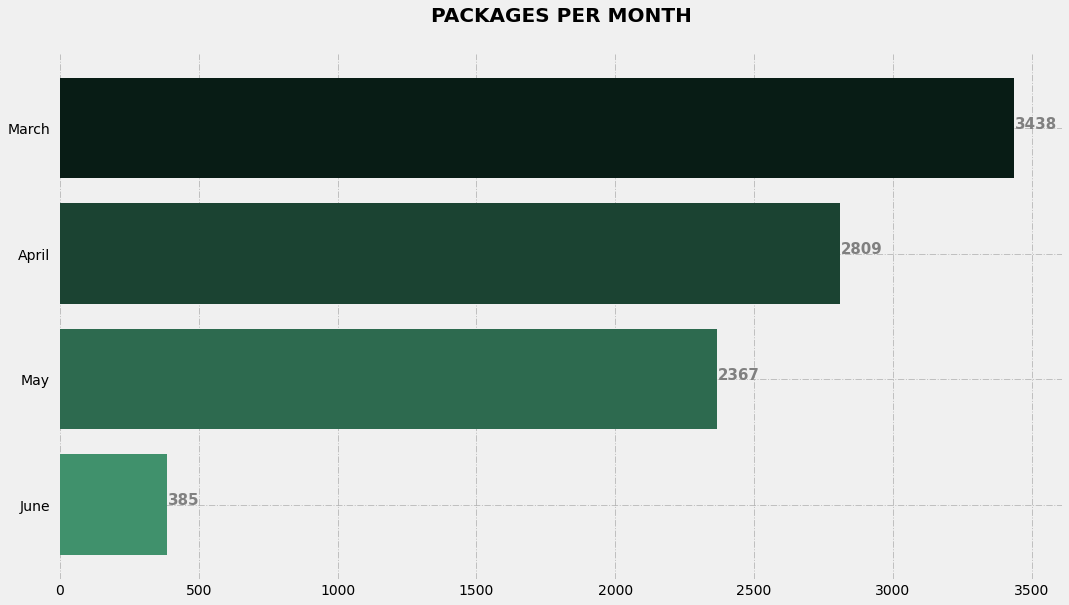

In [ ]:
bargraph_labels = ['March','April','May','June']
bargraph_values = bargraph_data.amount


bargraph_colors = ['#081c15','#1b4332','#2d6a4f','#40916c','#52b788','#74c69d','#95d5b2','#b7e4c7']

fig, ax = plt.subplots(figsize =(16, 9))

ax.barh(bargraph_labels, bargraph_values,color = bargraph_colors)

for s in ['top', 'bottom', 'left', 'right']:
	ax.spines[s].set_visible(False)

ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)

ax.grid(b = True, color ='black',
		linestyle ='-.', linewidth = 1,
		alpha = 0.2)

ax.invert_yaxis()

for i in ax.patches:
	plt.text(i.get_width()+3, i.get_y()+0.4,
			str(round((i.get_width()), 3)),
			fontsize = 15, fontweight ='bold',
			color ='grey')
ax.set_title('PACKAGES PER MONTH',loc ='center',fontdict={'fontsize':20,'fontweight':'bold'}, y=1.05  )
plt.show()


## ***DELIVERED VS UNDELIVERED***

In [ ]:
#Dataframe----------------------------------------------------------------------

from os import name
piechart_data = data.value_counts(['Delivery_Status']).rename_axis('Status').reset_index(name='amount')
piechart_data

,Status,amount
0,0.0,5336
1,1.0,3389


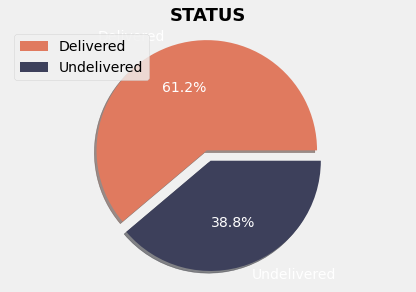

In [ ]:
#Set lables and values for piechart---------------------------------------------

piechart_labels = ['Delivered','Undelivered']
piechart_values = piechart_data.amount
exp = [0.1,0.0]
piechart_colors = ['#e07a5f','#3d405b']

plt.pie(piechart_values, labels = piechart_labels,explode= exp,shadow=True, autopct='%2.1f%%',textprops=dict(color="w",),colors=piechart_colors)
plt.style.use("fivethirtyeight")
plt.tight_layout()
plt.axis('equal')
plt.title('STATUS',fontdict={'fontsize':18,'fontweight':'bold'}) 
plt.legend(loc='upper left')



plt.show()

## ***DISTANCE VS DELIVERY***

In [ ]:
from enum import unique
#Dataframe----------------------------------------------------------------------

dataframe_origin = data[['Source','Delivery_Status']]



for country in dataframe_origin['Source']:

  for count in dataframe_origin['Delivery_Status']:
      
      

       


0        True
1        True
2       False
3       False
4       False
        ...  
8837    False
8838    False
8839    False
8840    False
8841    False
Name: Source, Length: 8750, dtype: bool